Copyright 2018 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

 [https://www.apache.org/licenses/LICENSE-2.0](https://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


# Conditional Neural Processes (CNP) for 1D regression.

[Conditional Neural Processes](https://arxiv.org/pdf/1807.01613.pdf) (CNPs) were
introduced as a continuation of
[Generative Query Networks](https://deepmind.com/blog/neural-scene-representation-and-rendering/)
(GQN) to extend its training regime to tasks beyond scene rendering, e.g. to
regression and classification.

In contrast to most standard neural networks, CNPs learn to approximate a
distribution over functions rather than approximating just a single function. As a result, at
test time CNPs are flexible and can approximate any function from this
distribution when provided with a handful of observations. In addition, they
learn to estimate the uncertainty of their prediction from the dataset and as
the number of observations is increased this uncertainty reduces and the
accuracy of their prediction increases.

In this notebook we describe the different parts of a CNP and apply the
resulting model to a 1D regression task where a CNP is trained on a dataset of
random functions.

Any thoughts or questions? We'd love any feedback (about this notebook or CNPs
in general) so just contact us at garnelo@google.com.

## Implementing CNPs

We start by importing the necessary dependencies. We will make use of numpy,
tensorflow, and matplotlib.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import collections

## Training data

A crucial property of CNPs is their flexibility at test time, as they can model
a whole range of functions and narrow down their prediction as we condition on
an increasing number of context observations. This behaviour is a result of the
training regime of CNPs which is reflected in our datasets.

![](https://bit.ly/2O2Lq8c)

Rather than training using observations from a single function as it is often
the case in machine learning (for example value functions in reinforcement
learning) we will use a dataset that consists of many different functions that
share some underlying characteristics. This is visualized in the figure above.
The example on the left corresponds to a classic training regime: we have a
single underlying ground truth function (eg. our value function for an agent) in
grey and at each learning iteration we are provided with a handful of examples from this
function that we have visualized in different colours for batches of different
iterations. On the right we show an example of a dataset that could be used for
training neural processes. Instead of a single function, it consists of a large number of functions of a function-class that we are interested in modeling. At each iteration we randomly choose one from the dataset and provide some observations from that function for training. For the next iteration we put that function back and
pick a new one from our dataset and use this new function to select the training
data. This type of dataset ensures that our model can't overfit to a single
function but rather learns a distribution over functions. This idea of a
hierarchical dataset also lies at the core of current meta-learning methods.
Examples of such datasets could be:

*  Functions describing the evolution of temperature over time in different cities 
of the world.
*  A dataset of functions generated by a motion capture sensor of different humans
    walking.
*   As in this particular example differents functions generated by a Gaussian process (GP)
    with a specific kernel.

We have chosen GPs for the data generation of this example because they
constitute an easy way of sampling smooth curves that share some underlying
characteristic (in this case the kernel). Other than for data generation of this
particular example neural processes do not make use of kernels or GPs as they
are implemented as neural networks.

## Data generator

In the following section we provide the code for generating our training and
testing sets using a GP to generate a dataset of functions. As we will explain
later, CNPs use two subset of points at every iteration: one to serve as the
context, and the other as targets. In practise we found that including the
context points as targets together with some additional new points helped during
training. Our data generator divides the generated data into these two groups
and provides it in the correct format.

In [2]:
# The CNP takes as input a `CNPRegressionDescription` namedtuple with fields:
#   `query`: a tuple containing ((context_x, context_y), target_x)
#   `target_y`: a tesor containing the ground truth for the targets to be
#     predicted
#   `num_total_points`: A vector containing a scalar that describes the total
#     number of datapoints used (context + target)
#   `num_context_points`: A vector containing a scalar that describes the number
#     of datapoints used as context
# The GPCurvesReader returns the newly sampled data in this format at each
# iteration

CNPRegressionDescription = collections.namedtuple(
    "CNPRegressionDescription",
    ("query", "target_y", "num_total_points", "num_context_points"))


class GPCurvesReader(object):
  """Generates curves using a Gaussian Process (GP).

  Supports vector inputs (x) and vector outputs (y). Kernel is
  mean-squared exponential, using the x-value l2 coordinate distance scaled by
  some factor chosen randomly in a range. Outputs are independent gaussian
  processes.
  """

  def __init__(self,
               batch_size,
               max_num_context,
               x_size=1,
               y_size=1,
               l1_scale=0.4,
               sigma_scale=1.0,
               testing=False):
    """Creates a regression dataset of functions sampled from a GP.

    Args:
      batch_size: An integer.
      max_num_context: The max number of observations in the context.
      x_size: Integer >= 1 for length of "x values" vector.
      y_size: Integer >= 1 for length of "y values" vector.
      l1_scale: Float; typical scale for kernel distance function.
      sigma_scale: Float; typical scale for variance.
      testing: Boolean that indicates whether we are testing. If so there are
          more targets for visualization.
    """
    self._batch_size = batch_size
    self._max_num_context = max_num_context
    self._x_size = x_size
    self._y_size = y_size
    self._l1_scale = l1_scale
    self._sigma_scale = sigma_scale
    self._testing = testing

  def _gaussian_kernel(self, xdata, l1, sigma_f, sigma_noise=2e-2):
    """Applies the Gaussian kernel to generate curve data.

    Args:
      xdata: Tensor with shape `[batch_size, num_total_points, x_size]` with
          the values of the x-axis data.
      l1: Tensor with shape `[batch_size, y_size, x_size]`, the scale
          parameter of the Gaussian kernel.
      sigma_f: Float tensor with shape `[batch_size, y_size]`; the magnitude
          of the std.
      sigma_noise: Float, std of the noise that we add for stability.

    Returns:
      The kernel, a float tensor with shape
      `[batch_size, y_size, num_total_points, num_total_points]`.
    """
    num_total_points = tf.shape(xdata)[1]

    # Expand and take the difference
    xdata1 = tf.expand_dims(xdata, axis=1)  # [B, 1, num_total_points, x_size]
    xdata2 = tf.expand_dims(xdata, axis=2)  # [B, num_total_points, 1, x_size]
    diff = xdata1 - xdata2  # [B, num_total_points, num_total_points, x_size]

    # [B, y_size, num_total_points, num_total_points, x_size]
    norm = tf.square(diff[:, None, :, :, :] / l1[:, :, None, None, :])

    norm = tf.reduce_sum(
        norm, -1)  # [B, data_size, num_total_points, num_total_points]

    # [B, y_size, num_total_points, num_total_points]
    kernel = tf.square(sigma_f)[:, :, None, None] * tf.exp(-0.5 * norm)

    # Add some noise to the diagonal to make the cholesky work.
    kernel += (sigma_noise**2) * tf.eye(num_total_points)

    return kernel

  def generate_curves(self):
    """Builds the op delivering the data.

    Generated functions are `float32` with x values between -2 and 2.
    
    Returns:
      A `CNPRegressionDescription` namedtuple.
    """
    num_context = tf.random_uniform(
        shape=[], minval=3, maxval=self._max_num_context, dtype=tf.int32)

    # If we are testing we want to have more targets and have them evenly
    # distributed in order to plot the function.
    if self._testing:
      num_target = 400
      num_total_points = num_target
      x_values = tf.tile(
          tf.expand_dims(tf.range(-2., 2., 1. / 100, dtype=tf.float32), axis=0),
          [self._batch_size, 1])
      x_values = tf.expand_dims(x_values, axis=-1)
    # During training the number of target points and their x-positions are
    # selected at random
    else:
      num_target = tf.random_uniform(
          shape=(), minval=2, maxval=self._max_num_context, dtype=tf.int32)
      num_total_points = num_context + num_target
      x_values = tf.random_uniform(
          [self._batch_size, num_total_points, self._x_size], -2, 2)

    # Set kernel parameters
    l1 = (
        tf.ones(shape=[self._batch_size, self._y_size, self._x_size]) *
        self._l1_scale)
    sigma_f = tf.ones(
        shape=[self._batch_size, self._y_size]) * self._sigma_scale

    # Pass the x_values through the Gaussian kernel
    # [batch_size, y_size, num_total_points, num_total_points]
    kernel = self._gaussian_kernel(x_values, l1, sigma_f)

    # Calculate Cholesky, using double precision for better stability:
    cholesky = tf.cast(tf.cholesky(tf.cast(kernel, tf.float64)), tf.float32)

    # Sample a curve
    # [batch_size, y_size, num_total_points, 1]
    y_values = tf.matmul(
        cholesky,
        tf.random_normal([self._batch_size, self._y_size, num_total_points, 1]))

    # [batch_size, num_total_points, y_size]
    y_values = tf.transpose(tf.squeeze(y_values, 3), [0, 2, 1])

    if self._testing:
      # Select the targets
      target_x = x_values
      target_y = y_values

      # Select the observations
      idx = tf.random_shuffle(tf.range(num_target))
      context_x = tf.gather(x_values, idx[:num_context], axis=1)
      context_y = tf.gather(y_values, idx[:num_context], axis=1)

    else:
      # Select the targets which will consist of the context points as well as
      # some new target points
      target_x = x_values[:, :num_target + num_context, :]
      target_y = y_values[:, :num_target + num_context, :]

      # Select the observations
      context_x = x_values[:, :num_context, :]
      context_y = y_values[:, :num_context, :]

    query = ((context_x, context_y), target_x)

    return CNPRegressionDescription(
        query=query,
        target_y=target_y,
        num_total_points=tf.shape(target_x)[1],
        num_context_points=num_context)

## Conditional Neural Processes

We can visualise a forward pass in a CNP as follows:

<img src="https://bit.ly/2OFb6ZK" alt="drawing" width="400"/>

As shown in the diagram, CNPs take in pairs **(x, y)<sub>i</sub>** of context
points, pass them through an **encoder** to obtain
individual representations **r<sub>i</sub>** which are combined using an **aggregator**. The resulting representation **r**
is then combined with the locations of the targets **x<sub>T</sub>** and passed
through a **decoder** that returns a mean estimate
of the **y** value at that target location together with a measure of the
uncertainty over said prediction. Implementing CNPs therefore involves coding up
the three main building blocks:

*   Encoder
*   Aggregator
*   Decoder

A more detailed description of these three parts is presented in the following
sections alongside the code.

## Encoder

The encoder **e** is shared between all the context points and consists of an
MLP with a handful of layers. For this experiment four layers are enough, but we
can still change the number and size of the layers when we build the graph later
on via the variable **`encoder_output_sizes`**. Each of the context pairs **(x,
y)<sub>i</sub>** results in an individual representation **r<sub>i</sub>** after
encoding. These representations are then combined across context points to form
a single representation **r** using the aggregator **a**.

In this implementation we have included the aggregator **a** in the encoder as
we are only taking the mean across all points. The representation **r** produced
by the aggregator contains the information about the underlying unknown function
**f** that is provided by all the context points.

In [3]:
class DeterministicEncoder(object):
  """The Encoder."""

  def __init__(self, output_sizes):
    """CNP encoder.

    Args:
      output_sizes: An iterable containing the output sizes of the encoding MLP.
    """
    self._output_sizes = output_sizes

  def __call__(self, context_x, context_y, num_context_points):
    """Encodes the inputs into one representation.

    Args:
      context_x: Tensor of size bs x observations x m_ch. For this 1D regression
          task this corresponds to the x-values.
      context_y: Tensor of size bs x observations x d_ch. For this 1D regression
          task this corresponds to the y-values.
      num_context_points: A tensor containing a single scalar that indicates the
          number of context_points provided in this iteration.

    Returns:
      representation: The encoded representation averaged over all context 
          points.
    """

    # Concatenate x and y along the filter axes
    encoder_input = tf.concat([context_x, context_y], axis=-1)

    # Get the shapes of the input and reshape to parallelise across observations
    batch_size, _, filter_size = encoder_input.shape.as_list()
    hidden = tf.reshape(encoder_input, (batch_size * num_context_points, -1))
    hidden.set_shape((None, filter_size))

    # Pass through MLP
    with tf.variable_scope("encoder", reuse=tf.AUTO_REUSE):
      for i, size in enumerate(self._output_sizes[:-1]):
        hidden = tf.nn.relu(
            tf.layers.dense(hidden, size, name="Encoder_layer_{}".format(i)))

      # Last layer without a ReLu
      hidden = tf.layers.dense(
          hidden, self._output_sizes[-1], name="Encoder_layer_{}".format(i + 1))

    # Bring back into original shape
    hidden = tf.reshape(hidden, (batch_size, num_context_points, size))

    # Aggregator: take the mean over all points
    representation = tf.reduce_mean(hidden, axis=1)

    return representation

## Decoder

Once we have obtained our representation **r** we concatenate it with each of
the targets **x<sub>t</sub>** and pass it through the decoder **d**. As with the
encoder **e**, the decoder **d** is shared between all the target points and
consists of a small MLP with layer sizes defined in **`decoder_output_sizes`**.
The decoder outputs a mean **&mu;<sub>t</sub>** and a variance
**&sigma;<sub>t</sub>** for each of the targets **x<sub>t</sub>**. To train our
CNP we use the log likelihood of the ground truth value **y<sub>t</sub>** under
a Gaussian parametrized by these predicted **&mu;<sub>t</sub>** and
**&sigma;<sub>t</sub>**.

In this implementation we clip the variance **&sigma;<sub>t</sub>** at 0.1 to
avoid collapsing.

In [4]:
class DeterministicDecoder(object):
  """The Decoder."""

  def __init__(self, output_sizes):
    """CNP decoder.

    Args:
      output_sizes: An iterable containing the output sizes of the decoder MLP 
          as defined in `basic.Linear`.
    """
    self._output_sizes = output_sizes

  def __call__(self, representation, target_x, num_total_points):
    """Decodes the individual targets.

    Args:
      representation: The encoded representation of the context
      target_x: The x locations for the target query
      num_total_points: The number of target points.

    Returns:
      dist: A multivariate Gaussian over the target points.
      mu: The mean of the multivariate Gaussian.
      sigma: The standard deviation of the multivariate Gaussian.
    """

    # Concatenate the representation and the target_x
    representation = tf.tile(
        tf.expand_dims(representation, axis=1), [1, num_total_points, 1])
    input = tf.concat([representation, target_x], axis=-1)

    # Get the shapes of the input and reshape to parallelise across observations
    batch_size, _, filter_size = input.shape.as_list()
    hidden = tf.reshape(input, (batch_size * num_total_points, -1))
    hidden.set_shape((None, filter_size))

    # Pass through MLP
    with tf.variable_scope("decoder", reuse=tf.AUTO_REUSE):
      for i, size in enumerate(self._output_sizes[:-1]):
        hidden = tf.nn.relu(
            tf.layers.dense(hidden, size, name="Decoder_layer_{}".format(i)))

      # Last layer without a ReLu
      hidden = tf.layers.dense(
          hidden, self._output_sizes[-1], name="Decoder_layer_{}".format(i + 1))

    # Bring back into original shape
    hidden = tf.reshape(hidden, (batch_size, num_total_points, -1))

    # Get the mean an the variance
    mu, log_sigma = tf.split(hidden, 2, axis=-1)

    # Bound the variance
    sigma = 0.1 + 0.9 * tf.nn.softplus(log_sigma)

    # Get the distribution
    dist = tf.contrib.distributions.MultivariateNormalDiag(
        loc=mu, scale_diag=sigma)

    return dist, mu, sigma

## Model

Now that the main building blocks (encoder, aggregator and decoder) of the CNP
are defined we can put everything together into one model. Fundamentally this
model only needs to include two main methods: 1. A method that returns the log
likelihood of the targets' ground truth values under the predicted
distribution.This method will be called during training as our loss function. 2.
Another method that returns the predicted mean and variance at the target
locations in order to evaluate or query the CNP at test time. This second method
needs to be defined separately as, unlike the method above, it should not depend
on the ground truth target values.

In [5]:
class DeterministicModel(object):
  """The CNP model."""

  def __init__(self, encoder_output_sizes, decoder_output_sizes):
    """Initialises the model.

    Args:
      encoder_output_sizes: An iterable containing the sizes of hidden layers of
          the encoder. The last one is the size of the representation r.
      decoder_output_sizes: An iterable containing the sizes of hidden layers of
          the decoder. The last element should correspond to the dimension of
          the y * 2 (it encodes both mean and variance concatenated)
    """
    self._encoder = DeterministicEncoder(encoder_output_sizes)
    self._decoder = DeterministicDecoder(decoder_output_sizes)

  def __call__(self, query, num_total_points, num_contexts, target_y=None):
    """Returns the predicted mean and variance at the target points.

    Args:
      query: Array containing ((context_x, context_y), target_x) where:
          context_x: Array of shape batch_size x num_context x 1 contains the 
              x values of the context points.
          context_y: Array of shape batch_size x num_context x 1 contains the 
              y values of the context points.
          target_x: Array of shape batch_size x num_target x 1 contains the
              x values of the target points.
      target_y: The ground truth y values of the target y. An array of 
          shape batchsize x num_targets x 1.
      num_total_points: Number of target points.

    Returns:
      log_p: The log_probability of the target_y given the predicted
      distribution.
      mu: The mean of the predicted distribution.
      sigma: The variance of the predicted distribution.
    """

    (context_x, context_y), target_x = query

    # Pass query through the encoder and the decoder
    representation = self._encoder(context_x, context_y, num_contexts)
    dist, mu, sigma = self._decoder(representation, target_x, num_total_points)

    # If we want to calculate the log_prob for training we will make use of the
    # target_y. At test time the target_y is not available so we return None
    if target_y is not None:
      log_p = dist.log_prob(target_y)
    else:
      log_p = None

    return log_p, mu, sigma

## Plotting function
We define a helper function for plotting the intermediate predictions
every `PLOT_AFTER` iterations. The ground truth curve will be shown as a black
dotted line and the context points from this curve that are fed into the model
as black dots. The model's predicted mean and variance is shown in blue for a
range of target points in the interval [-2, 2].

In [6]:
def plot_functions(target_x, target_y, context_x, context_y, pred_y, var):
  """Plots the predicted mean and variance and the context points.
  
  Args: 
    target_x: An array of shape batchsize x number_targets x 1 that contains the
        x values of the target points.
    target_y: An array of shape batchsize x number_targets x 1 that contains the
        y values of the target points.
    context_x: An array of shape batchsize x number_context x 1 that contains 
        the x values of the context points.
    context_y: An array of shape batchsize x number_context x 1 that contains 
        the y values of the context points.
    pred_y: An array of shape batchsize x number_targets x 1  that contains the
        predicted means of the y values at the target points in target_x.
    pred_y: An array of shape batchsize x number_targets x 1  that contains the
        predicted variance of the y values at the target points in target_x.
  """
  # Plot everything
  plt.plot(target_x[0], pred_y[0], 'b', linewidth=2)
  plt.plot(target_x[0], target_y[0], 'k:', linewidth=2)
  plt.plot(context_x[0], context_y[0], 'ko', markersize=10)
  plt.fill_between(
      target_x[0, :, 0],
      pred_y[0, :, 0] - var[0, :, 0],
      pred_y[0, :, 0] + var[0, :, 0],
      alpha=0.2,
      facecolor='#65c9f7',
      interpolate=True)

  # Make the plot pretty
  plt.yticks([-2, 0, 2], fontsize=16)
  plt.xticks([-2, 0, 2], fontsize=16)
  plt.ylim([-2, 2])
  plt.grid('off')
  ax = plt.gca()
  ax.set_facecolor('white')
  plt.show()

## Running Conditional Neural Processes

Now that we have defined the dataset as well as our model and its components we
can start building everything into the graph. Before we get started we need to
set some variables:

*   **`TRAINING_ITERATIONS`** - a scalar that describes the number of iterations
    for training. At each iteration we will sample a new batch of functions from
    the GP, pick some of the points on the curves as our context points **(x,
    y)<sub>C</sub>** and some points as our target points **(x,
    y)<sub>T</sub>**. We will predict the mean and variance at the target points
    given the context and use the log likelihood of the ground truth targets as
    our loss to update the model.
*   **`MAX_CONTEXT_POINTS`** - a scalar that sets the maximum number of contest
    points used during training. The number of context points will then be a
    value between 3 and `MAX_CONTEXT_POINTS` that is sampled at random for every
    iteration.
*   **`PLOT_AFTER`** - a scalar that regulates how often we plot the
    intermediate results.

In [7]:
TRAINING_ITERATIONS = int(2e5)
MAX_CONTEXT_POINTS = 10
PLOT_AFTER = int(2e4)
tf.reset_default_graph()

We add the dataset reader to the graph for both the training and the testing
set. As mentioned above for this experiment the dataset consists of functions
that are sampled anew from a GP at each iteration. The main difference between
train and test in this case is that the test set contains more targets so that
we can plot the entire curve, whereas the training set only contains a few
target points to predict.

In [8]:
# Train dataset
dataset_train = GPCurvesReader(
    batch_size=64, max_num_context=MAX_CONTEXT_POINTS)
data_train = dataset_train.generate_curves()

# Test dataset
dataset_test = GPCurvesReader(
    batch_size=1, max_num_context=MAX_CONTEXT_POINTS, testing=True)
data_test = dataset_test.generate_curves()

We can now add the model to the graph and finalise it by defining the train step
and the initializer.

In [9]:
# Sizes of the layers of the MLPs for the encoder and decoder
# The final output layer of the decoder outputs two values, one for the mean and
# one for the variance of the prediction at the target location
encoder_output_sizes = [128, 128, 128, 128]
decoder_output_sizes = [128, 128, 2]

# Define the model
model = DeterministicModel(encoder_output_sizes, decoder_output_sizes)

# Define the loss
log_prob, _, _ = model(data_train.query, data_train.num_total_points,
                       data_train.num_context_points, data_train.target_y)
loss = -tf.reduce_mean(log_prob)

# Get the predicted mean and variance at the target points for the testing set
_, mu, sigma = model(data_test.query, data_test.num_total_points,
                     data_test.num_context_points)

# Set up the optimizer and train step
optimizer = tf.train.AdamOptimizer(1e-4)
train_step = optimizer.minimize(loss)
init = tf.initialize_all_variables()

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). 

We are ready to train the model! During training we will plot some intermediate
predictions to visualize how the model evolves.

Every `PLOT_AFTER` iterations we print out the loss, which corresponds to the
negative log probability of the ground truth targets under the predicted
distribution. As the model is trained this value should decrease.

In addition we are going to plot the predictions of our model alongside the
ground truth curve and the context points that the CNP is provided at that
iteration.

2025-01-29 18:03:59.188275: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2025-01-29 18:03:59.203781: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1796490000 Hz
2025-01-29 18:03:59.205254: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x5d18623519a0 executing computations on platform Host. Devices:
2025-01-29 18:03:59.205291: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>


Iteration: 0, loss: 1.5765732526779175


/home/eric/.pyenv/versions/3.7.17/envs/ml-seminar/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


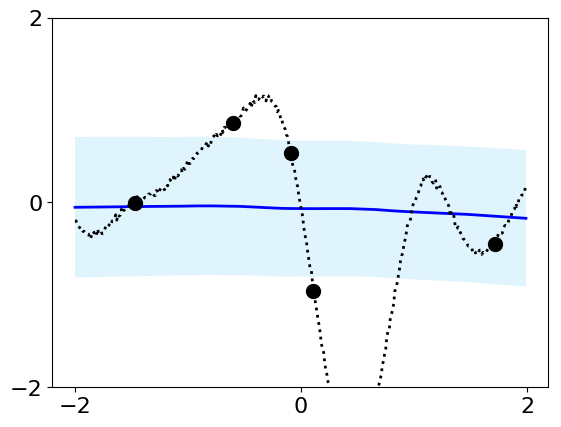

Iteration: 20000, loss: 0.8248720169067383


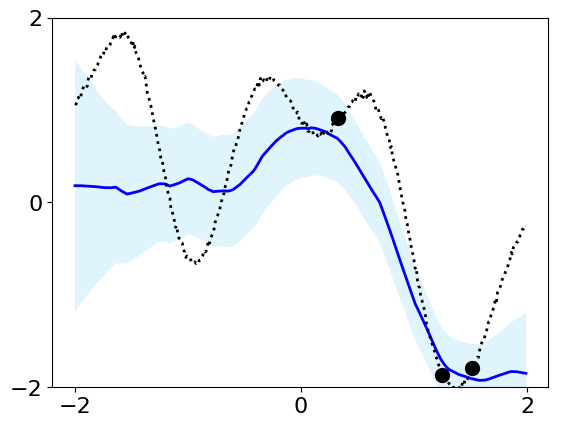

In [ ]:
with tf.Session() as sess:
  sess.run(init)

  for it in range(TRAINING_ITERATIONS):
    sess.run([train_step])

    # Plot the predictions in `PLOT_AFTER` intervals
    if it % PLOT_AFTER == 0:
      loss_value, pred_y, var, target_y, whole_query = sess.run(
          [loss, mu, sigma, data_test.target_y, data_test.query])

      (context_x, context_y), target_x = whole_query
      print('Iteration: {}, loss: {}'.format(it, loss_value))

      # Plot the prediction and the context
      plot_functions(target_x, target_y, context_x, context_y, pred_y, var)